## Introduction

Logistic Regression is one of the most known and popular methods for conducting binary classification. In this part I have followed [this](http://kseow.com/logisticregression/) article that has great theoritical explanation. Using it's explanation I have programmed my own Logistic Regression algorithm. My goal is to compare it to the algorithm offered by scikit-learn.


In [1]:
# Data analysis
import numpy as np
import pandas as pd
import random as rnd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression Import
import math
from sklearn.linear_model import LogisticRegression

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

But first of all, I need to create a quick pipeline for the data to be ready for the algorithm. Basically, this is a code that does all the feature engineering described in the "Data Exploration" notebook.

In [3]:
# Removing PassengerId
train_df = train_df.drop('PassengerId', axis=1)

# Convering 'Name'
name_df = train_df.Name.str.split(expand = True)
train_df['Name'] = name_df[1]
train_df.loc[(train_df['Name'] != 'Mr.') & (train_df['Name'] != 'Mrs.') & (train_df['Name'] != 'Miss.') & (train_df['Name'] != 'Master.'), 'Name'] = 'Other'

# Converting 'Ticket'
train_df['Ticket'] = train_df['Ticket'].map(train_df['Ticket'].value_counts()).astype('int64')

# Converting 'Cabin'
train_df['Cabin'] = train_df['Cabin'].notnull().astype('int64')

# Remove missing values of 'Embarked'
train_df = train_df[train_df.Embarked.notnull()]
# Fill missing values with mean value
train_df = train_df.fillna(train_df.Age.mean())

# Encoding 'Sex' categorical data into a numeric columns
train_df.loc[train_df.Sex == 'male', 'Sex'] = 0
train_df.loc[train_df.Sex == 'female', 'Sex'] = 1
train_df['Sex'].astype('int64')
# Encoding 'Name' categorical data using 'One Hot' method - get_dummies in pandas
train_df = pd.get_dummies(train_df, columns=['Embarked'], prefix = ['embarked'])
train_df = pd.get_dummies(train_df, columns=['Name'], prefix = ['name'])

# Transforming to 'FamilyTicket'
train_df['FamilyTicket'] = train_df.apply(lambda row: (row.Parch + row.SibSp) / row.Ticket, axis=1)

train_df = train_df.drop('Parch', axis=1)
train_df = train_df.drop('SibSp', axis=1)
train_df = train_df.drop('Ticket', axis=1)

# Removing 'Sex' feature
train_df = train_df.drop('Sex', axis=1)

# Finding the PCA component for these three features
from sklearn.preprocessing import StandardScaler
x = train_df.loc[:, ['Pclass', 'Cabin', 'Fare']].values
x = StandardScaler().fit_transform(x) # normalizing the features
x = pd.DataFrame(x)
from sklearn.decomposition import PCA
pca_class_model = PCA(n_components=1)
pca_class = pca_class_model.fit_transform(x)
train_df['PCA_Class'] = pca_class

train_df = train_df.drop('Cabin', axis=1)
train_df = train_df.drop('Fare', axis=1)
train_df = train_df.drop('Pclass', axis=1)

# Re-Endocing Embarked
train_df.loc[train_df.embarked_S == 1, 'embarked_C'] = '-1'

train_df = train_df.rename(columns={'embarked_C': 'Embarked'})
train_df = train_df.drop('embarked_Q', axis=1)
train_df = train_df.drop('embarked_S', axis=1)

train_df['Embarked'] = pd.to_numeric(train_df.Embarked)


Now I need to normalize all values to be in the segment [-1,1] so that the model will have equal influence by each feature. Afterward I will split the dependant variable from the features.

In [4]:
# Splitting to features and dependant variable
X = train_df.drop('Survived', 1)
y = train_df.Survived

# Scaling Features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
X = pd.DataFrame(scaler.fit_transform(X))


# My Logistic Regression Model
Now I have to build functions to implement the logistic regression.
Basically, a logistic regression is a function that finds linear disrimininant function that is represented as a linear combination of all the features. This function is then queezed into a sigmoid function which generates the aposteriori probability of each sample to belong to the class. If the probability is higher than 50% then we'll classify the sample as a part of the class (y=1), otherwise we will say that it doesn't belong to the class (y=0). The goal of the learning process is to find the perfect weights of each feature so it will be the best discriminator.

### Calculate Sigmoid Value
That function calculates the value of the sigomid function. It gets vectors of weights and a vector of features, and returns a vector of probabilities. Each element in the output vector represents the chance that the specific sample belongs to the class.

In [5]:
def calculate_sigmoid_value(features, weights):
    p_of_y = []
    for i in features.index:
        dot_result = np.dot(features.loc[i], weights)
        p_of_y.append(math.exp(dot_result) / (1 + math.exp(dot_result)))
    return p_of_y

### Calculate Cost Function Value
As described in the article, our cost function should take into account that there is an exponential ratio between changing weights and changing the probabilities of the samples. Therefore, the cost function will be as following:

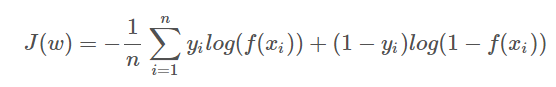

The function gets all the required parameters for calculations, and returns the sum of the cost function for all the samples combined. The goal of the learning process is to minimize that value.

In [6]:
def calculate_cost_function_value(p_of_y, y, weights):
    y_sum = 0
    i = 0
    for y_sample in y:
        y_sum = y_sum - y_sample*math.log(p_of_y[i]) - (1-y_sample)*math.log(1-p_of_y[i])
        i = i +1
    y_sum = y_sum / len(y)    
   # print(y_sum)
    return (y_sum)    

### Gradient Descent

The learning process will happen using gradient descent algorithm. It is well explained in the article how this algorithm able to find the minimum points of the cost function. My function is taking a small step each time towards that point, and then generates new weights vector and returns it.

In [7]:
def gradient_descent(weights, learning_rate, features, y, p_of_y):
    new_weights=[]
   
    for w in range(0,len(weights)):
        sum_of_error = np.dot(p_of_y-y, features.iloc[:,w])
        new_weights.append(weights[w]-learning_rate*sum_of_error)
    return new_weights

### Learn
This is the function that is responsible for the learning process. I have decided to run 100 iterations before returning the weights vector, which is the result of our learning process. I have also returned a vector which contains the values of the cost function in each iteration, so I will be able to plot it over time. 

In [8]:
def learn(weights, features,y):
    Costs = []
    new_weights = weights
    for i in range(0,100):
        p_of_y = calculate_sigmoid_value(features,new_weights)
        Costs.append(calculate_cost_function_value(p_of_y,y,new_weights))
        new_weights = gradient_descent(new_weights,0.001,features,y,p_of_y)
    return new_weights, Costs    

### Predict

This function calculates the value of the sigmoid function for each sample, and then translates it into a binary prediction for each sample, based on the decision rule previously described.

In [9]:
def predict(x_values, weights):
    class_predictions = []
    prob_predictions = calculate_sigmoid_value(x_values, weights)
    for prob in prob_predictions:
        if prob > 0.5:
            class_predictions.append(1)
        else:
            class_predictions.append(0)
    return class_predictions        

Now I am ready to run my algorithm. Since I want to compare the results of the algorithm to another algorithms, I have decided to use 10-Fold Cross Validation. At the end of the process I am printing the accuracy rate of the model on the test data.

In [10]:
from sklearn.model_selection import KFold
accuracy_rates = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    # The initial vector of weights should be zero.
    weights = [0] * len(X.columns)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    new_weights, costs = learn(weights, X_train, y_train)
    y_values_train = predict(X_test, new_weights)
    diff = y_values_train - y_test
    accuracy_rates.append(1.0 - (float(np.count_nonzero(diff)) / len(diff)))
print(accuracy_rates)


[0.7865168539325843, 0.7865168539325843, 0.7640449438202247, 0.8539325842696629, 0.7752808988764045, 0.7865168539325843, 0.7415730337078652, 0.7752808988764045, 0.8651685393258427, 0.7954545454545454]


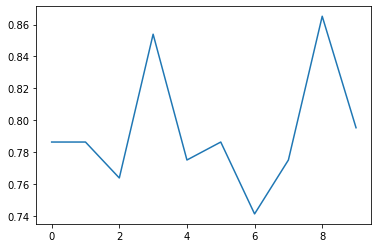

In [11]:
x = []
for i in range(0,10):
    x.append(i)
sns.lineplot(x=x, y=accuracy_rates)

In [12]:
from statistics import mean
print("The average accuracy rate is: " +str(mean(accuracy_rates)))

The average accuracy rate is: 0.7930286006128703


### Summary - My Logistic Regression

We can see that my algorithm took quite a lot of time to run. As to the accuracy rates, there was quite a large variance between the different folds, where the lowest would be 0.74 and the highest is 0.865. The average rate is not bad - 0.793 percent. 

# SciKit-learn Logistic Regression

Now I'm gonna run logistic regression as available in the popular scikit-learn package.

In [13]:
from sklearn.model_selection import KFold
scikit_accuracy_rates = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
logmodel = LogisticRegression()

for train_index, test_index in cv.split(X):
    # The initial vector of weights should be zero.
    weights = [0] * len(X.columns)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logmodel.fit(X_train, y_train)
   # iter_list=[]
   # for i in range(0,100):
   #     iter_list.append(i)    
   # sns.lineplot(x=iter_list, y=costs)
    y_values_train = logmodel.predict(X_test)
    diff = y_values_train - y_test
    scikit_accuracy_rates.append(1.0 - (float(np.count_nonzero(diff)) / len(diff)))
print(scikit_accuracy_rates)


[0.7752808988764045, 0.8089887640449438, 0.7640449438202247, 0.8539325842696629, 0.7640449438202247, 0.7865168539325843, 0.752808988764045, 0.7752808988764045, 0.8426966292134832, 0.7727272727272727]


c:\users\tomha\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tomha\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tomha\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tomha\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tomha\appdata\local\programs\python\pyt

The average accuracy rate is: 0.789632277834525


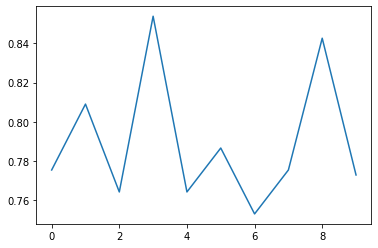

In [14]:
x = []
for i in range(0,10):
    x.append(i)
sns.lineplot(x=x, y=scikit_accuracy_rates)

from statistics import mean
print("The average accuracy rate is: " +str(mean(scikit_accuracy_rates)))

## Summary

In a somewhat surprising manner, while being extensively inferior in terms of performance, my logistic regression got slightly better results than scikit-learn's one. 
The main difference between the two models is that Scikit's model uses a penalty function that tries to avoid multicolinearity. The default penalty function is "L2" which is also known as <b>Ridge Regression</b>. That means that the model adds the "squared magnitude" of coefficient as penalty term to the loss function. 

To some extent, I have already took care of the model regularization since I have extraced the main PCA component. 
Let's try and tweek some parameters in the model, and hopefully we'll be able to come up with improved results.


In [91]:
from sklearn.model_selection import KFold
scikit_accuracy_rates_2 = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
probabilities = {0: 0.676, 1: 0.324}
# Creating a dictionary to the aposteriori probabilities
logmodel = LogisticRegression(penalty='none', class_weight=probabilities, solver='saga')

for train_index, test_index in cv.split(X):
    # The initial vector of weights should be zero.
    weights = [0] * len(X.columns)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logmodel.fit(X_train, y_train)
   # iter_list=[]
   # for i in range(0,100):
   #     iter_list.append(i)    
   # sns.lineplot(x=iter_list, y=costs)
    y_values_train = logmodel.predict(X_test)
    diff = y_values_train - y_test
    scikit_accuracy_rates_2.append(1.0 - (float(np.count_nonzero(diff)) / len(diff)))
print(scikit_accuracy_rates_2)

[0.752808988764045, 0.8426966292134832, 0.7752808988764045, 0.7865168539325843, 0.7865168539325843, 0.797752808988764, 0.7191011235955056, 0.752808988764045, 0.8426966292134832, 0.8522727272727273]


The average accuracy rate is: 0.7908452502553627


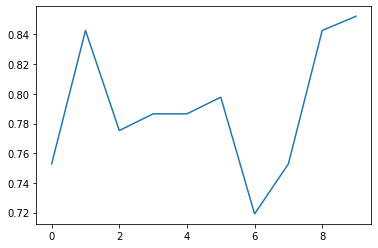

In [92]:
x = []
for i in range(0,10):
    x.append(i)
sns.lineplot(x=x, y=scikit_accuracy_rates_2)

from statistics import mean
print("The average accuracy rate is: " +str(mean(scikit_accuracy_rates_2)))

In this new model I have removed the regularization factor. The default solver - "liblinear" does not support running the regression with no regularization, therefore I have changed the solver to be "saga". That means that I have changed the learning algorithm accordingly.

<b>liblinear</b> is a learning algorithm based on a library with the same name that was first introduced in 2008. It supports large scale linear classification. When using it with Ridge Regression penalty factor, it operates a learning algorithm called ["Trust Region Newton Method"](https://www.csie.ntu.edu.tw/~cjlin/papers/logistic.pdf).

<b>saga</b>, on the other hand, is based on ["Stochastic Average Gradient"](https://www.cs.ubc.ca/~schmidtm/Courses/540-W18/L11.pdf) learning method. According to Scikit Documentation: The SAGA solver is often the best choice.

I have also created a dictionary to feed the algorithm with the aposteriori probabilities of the classes, since it is already known.

Those changes gained a slight improvement, as this regression is still inferior compared to mine.

In [181]:

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

0.8035714285714286
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        98
           1       0.75      0.79      0.77        70

    accuracy                           0.80       168
   macro avg       0.80      0.80      0.80       168
weighted avg       0.81      0.80      0.80       168



In [494]:
# Pipeline for test data

submit_df = test_df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Fill missing data
submit_df = submit_df.fillna(submit_df.Age.mean())

# Encoding 'Sex' categorical data into a numeric columns
submit_df.loc[submit_df.Sex == 'male', 'Sex'] = 0
submit_df.loc[submit_df.Sex == 'female', 'Sex'] = 1
submit_df['Sex'].astype('int64')
# Encoding 'Embarked' categorical data using 'One Hot' method - get_dummies in pandas
submit_df = pd.get_dummies(submit_df, columns=['Embarked'], prefix = ['embarked'])
# submit_df['family'] = submit_df.apply(lambda row: row.Parch / (row.SibSp + row.Age + 1), axis=1)

df_for_model = submit_df[['PassengerId', 'Pclass', 'Sex', 'Parch', 'SibSp', 'Age', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S']]
x_test = df_for_model.values #returns a numpy array

# Scaling
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_test_scaled = min_max_scaler.fit_transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled)

In [495]:
y_test = predict(x_test_scaled, new_weights)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_test
    })
submission.to_csv('submission.csv', index=False)

In [182]:
# Pipeline for test data

submit_df = test_df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Fill missing data
submit_df = submit_df.fillna(submit_df.Age.mean())

# Encoding 'Sex' categorical data into a numeric columns
submit_df.loc[submit_df.Sex == 'male', 'Sex'] = 0
submit_df.loc[submit_df.Sex == 'female', 'Sex'] = 1
submit_df['Sex'].astype('int64')
# Encoding 'Embarked' categorical data using 'One Hot' method - get_dummies in pandas
submit_df = pd.get_dummies(submit_df, columns=['Embarked'], prefix = ['embarked'])
submit_df['family'] = submit_df.apply(lambda row: row.Parch / (row.SibSp + row.Age + 1), axis=1)

df_for_model = submit_df[['PassengerId', 'Pclass', 'Sex', 'family', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S']]
x_test = df_for_model.values #returns a numpy array

# Scaling
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_test_scaled = min_max_scaler.fit_transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled)

In [183]:
y_test = logmodel.predict(x_test_scaled)

ValueError: X has 8 features per sample; expecting 5

In [184]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_test
    })
submission.to_csv('submission.csv', index=False)